In [1]:
from dotenv import load_dotenv

from ipynb.income_tax_graph import AgentState

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

small_llm = ChatOpenAI(model='gpt-4o-mini')


In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b
@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()



In [5]:
from langgraph.prebuilt import ToolNode


tool_list = [add, multiply, search_tool]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [9]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [10]:
def agent(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': response}

In [11]:
from typing import Literal
from langgraph.types import interrupt, Command

def human_review(state: AgentState) -> Command[Literal['tools']]:
    messages = state['messages']
    last_message = messages[-1]
    tool_call = last_message.tool_calls[-1]
    human_review = interrupt({
        'question': '이렇게 진행하면 될까요?',
        'tool_call': tool_call,
    })
    review_action = human_review['action']
    review_data = human_review.get('data', None)

    if review_action == 'continue':
        return Command(goto='tools')

In [12]:
from langgraph.graph import END

def should_continue(state: MessagesState):
    messages = state['messages']
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return 'human_review'
    return END

In [13]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(human_review)

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END],
)
graph_builder.add_edge('tools', 'agent')

In [15]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph = graph_builder.compile(
    checkpointer=checkpointer,
)

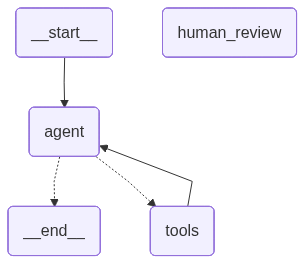

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': 'paper_summary'
    }
}

query = 'What currency is an Billy Giles\' birthplace?'
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values', config=config):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

What currency is an Billy Giles' birthplace?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_Ng7Trnv79fCeDOk7rTT3DUzy)
 Call ID: call_Ng7Trnv79fCeDOk7rTT3DUzy
  Args:
    query: Billy Giles birthplace
================================= Tool Message =================================
Name: duckduckgo_search

Billy Giles was an Ulster Volunteer Force volunteer who later became active in politics following his release from the Maze Prison in 1997 after serving 14 years of a life sentence for murder. However, Giles Deacon designed cloth for many celebrities like Pink, Cara Delevigne, Billy Porter, Cate Blanchett, Grace Kelly, and many more. Giles designed the dress for Cate Blanchett at the 2015 Cannes Film Festival which was also voted the best dress at the festival in 2015 and second ... Welsh TV Personality Annabel Giles was born Annabel 

In [14]:
# update_query = '출처 url도 같이 알려주세요'
# for chunk in graph.stream({'messages': [HumanMessage(update_query)]}, stream_mode='values', config=config):
#     chunk['messages'][-1].pretty_print()